# Instructions:
In the notebook below you will be implementing an image compression algorithm.  
In some parts you will be asked to write a block of code.  
In other parts you will be asked a Question and will need to write an answer in the following block.

This programming exercise will walk you through all the steps, borrow from what we've learned, and produce a final prodct.  If at any point you get stuck on one block of code or it doesn't create the correct output, you can skip that block and move onto the next.  To allow for this, we've uploaded our versions of the "check points" from each block of code.

Say you've gotten stuck on $Block_i$.  On Canvas we have files called $Output\_Block\_i$.  Download them, and read them as input to $Block_{i+1}$.  Then continue writing and running your code for $Block_{i+1}$.  If you do this, you may lose points on $Block_i$ since it is uncompleted or incorrect, but you are still elligable for full points on $Block_{i+1}$.  This way, you can complete the code in sections in case you get stuck.  

In order to receive a perfect score on the coding part this problem, you must be able to run your code correctly from beginning to end (and get the correct output) without loading in any of our check points.  

# Image Compression

For an 8 megapixel camera, the raw size of an image woudl be 8 millions pixels times 3 color channels (red-green-blue or RGB) times 8-bits (or 1 byte) to represent each color-channel.
Overall this would result in a file size of 24 Megabytes. However if you check the images you take with your cell-phone the actual file-size is much smaller than that (around 10% of the raw image size).
That's because the image is compressed prior to storage. One of the most popular compression techniques is JPEG.

During the course we've been learning about frequency domain transforms and the advantage of such transforms to sparsely represent data.This means that for a high dimensional signal of length $n$, by converting it to the frequency domain we need $d \ll n $ elements to represent most of the information in a signal.
One of the most extreme examples are a sinusoid of length $n$ and frequency $f_0$ which in the DFT domain has only $2 \ll n $ non-zero elements. 

In this project, we will learn and implement a modified version of the JPEG image compression algorithm. JPEG is a **lossy** image compression algorithm relying on a frequency domain transform called DCT. By reducing or removing high-frequency information, the image can be represented using  a significantly smaller number of elements than $n_{rows} \times n_{columns}$ pixels. Image compression (and signal compression in general) is important for efficient data storage and sharing.   
Note that the actual implementation of JPEG differs from the implementation below and relies on coding theory which we have not covered in the course.

## 0) Background: The Discrete Cosine Transform (DCT)

We bein with defining the DCT and inverse DCT two-dimensional transforms (scipy only implements the 1D version of the DCT).  
The DCT as opposed to the DFT is a real-valued transform based on cosines and given by 
$$ D[u,v]=\alpha_{u}\alpha_{v} \sum_{m=0}^{M-1}\sum_{n=0}^{N-1}I[m,n]\cos(\frac{\pi(2m+1)u}{2M})\cos(\frac{\pi(2n+1)v}{2N}),$$ where $0\leq u \leq M-1,\quad 0 \leq v \leq N-1$ and 
$$ \alpha_u =  \begin{cases} 
1/\sqrt{M},\quad u=0 \\
\sqrt{2/M}, \quad  1\leq u \leq M-1
\end{cases} $$ and
$$ \alpha_v =  \begin{cases} 
1/\sqrt{N},\quad v=0 \\
\sqrt{2/N}, \quad  1\leq v \leq N-1
\end{cases}. $$  
Note that this is still a frequency-based transformation of the data, however as opposed to the DFT its basis funcitons are real cosine signals of increasing frequency, as opposed to the complex exponential basis fucntions of the DFT.

The inverse transform, IDCT, in 2D is given by 
$$ I[m,n]=\sum_{u=0}^{M-1}\sum_{v=0}^{N-1} \alpha_{u}\alpha_{v} D[u,v]\cos(\frac{\pi(2m+1)u}{2M})\cos(\frac{\pi(2n+1)v}{2N}),$$ where $0\leq m \leq M-1,\quad 0 \leq n \leq N-1$ and 
$$ \alpha_u =  \begin{cases} 
1/\sqrt{M},\quad u=0 \\
\sqrt{2/M}, \quad  1\leq u \leq M-1
\end{cases} $$ and
$$ \alpha_v =  \begin{cases} 
1/\sqrt{N},\quad v=0 \\
\sqrt{2/N}, \quad  1\leq v \leq N-1
\end{cases}. $$  

We define 2 functions applying the 2D DCT and IDCT to a 2D input (note we are using the orthonormal version of the transform as defiend above)

In [15]:
import numpy as np
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import scipy
from skimage.transform import resize
import pywt
import matplotlib
from PIL import Image

In [5]:
def dct2(a):
    return scipy.fft.dct( scipy.fft.dct( a, axis=0, norm='ortho' ), axis=1, norm='ortho' )

def idct2(a):
    return scipy.fft.idct( scipy.fft.idct( a, axis=0 , norm='ortho'), axis=1 , norm='ortho')

Note: if the above code doesn't work for you then uncomment and use the block below (uses scipy.fftpack instead of scipy.fft)

In [ ]:
# def dct2(a):
#    return scipy.fft.dct( scipy.fftpack.dct( a, axis=0, norm='ortho' ), axis=1, norm='ortho' )
#
# def idct2(a):
#    return scipy.fft.idct( scipy.fftpack.idct( a, axis=0 , norm='ortho'), axis=1 , norm='ortho')

Let's plot the basis functions of the $8 \times 8$ 2D-DCT. Each $8\times 8$ block in the image below is one of the 64 basis functions. The DCT transforms an $8 \times 8$ block of input values to a linear combination of these 64 "patterns", which are the two-dimensional DCT basis functions. The output values are referred to as transform coefficients.

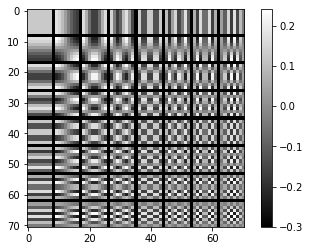

In [6]:
I = -0.3*np.ones((8*8+7,8*8+7))

for r in range(0,8):
    for c in range(0,8):
        block = np.zeros((8,8))
        block[r,c] = 1
        I[(r*8+r):(r*8+r)+8,(c*8+c):(c*8+c)+8] = idct2(block)

plt.imshow(I,cmap='gray')
plt.colorbar()
plt.show()

### Question
Using the definition of the IDCT, explain why this code 
```
block = np.zeros((8,8))
block[u,v] = 1
idct2(block)```

produces the 2D-DCT basis function of frequency $(u,v)$.

In [6]:
block = np.zeros((8,8))
block[1,1] = 1
idct2(block)

array([[ 0.24048494,  0.20387329,  0.13622378,  0.04783543, -0.04783543,
        -0.13622378, -0.20387329, -0.24048494],
       [ 0.20387329,  0.17283543,  0.11548494,  0.04055292, -0.04055292,
        -0.11548494, -0.17283543, -0.20387329],
       [ 0.13622378,  0.11548494,  0.07716457,  0.02709659, -0.02709659,
        -0.07716457, -0.11548494, -0.13622378],
       [ 0.04783543,  0.04055292,  0.02709659,  0.00951506, -0.00951506,
        -0.02709659, -0.04055292, -0.04783543],
       [-0.04783543, -0.04055292, -0.02709659, -0.00951506,  0.00951506,
         0.02709659,  0.04055292,  0.04783543],
       [-0.13622378, -0.11548494, -0.07716457, -0.02709659,  0.02709659,
         0.07716457,  0.11548494,  0.13622378],
       [-0.20387329, -0.17283543, -0.11548494, -0.04055292,  0.04055292,
         0.11548494,  0.17283543,  0.20387329],
       [-0.24048494, -0.20387329, -0.13622378, -0.04783543,  0.04783543,
         0.13622378,  0.20387329,  0.24048494]])

### Answer

Because there will be a pixel present in the region of the respctive dft space that maps to the basis function of that region.

## 1) Importing and preprocessing an image 

This part of the code will load an image and preprocess it.

In the following block, write code to 
- input an image to the notebook. 
- convert the image from an RGB (3 color channel image of size $M \times N \times 3$) to grayscale (image of size $M \times N$).
- resize the image to $512 \times 512$. 
- plot your image in grayscale and include a colorbar.

You can use functions from numpy, scipy and skimage that were loaded in the preamble in part 0).

<Figure size 432x288 with 0 Axes>

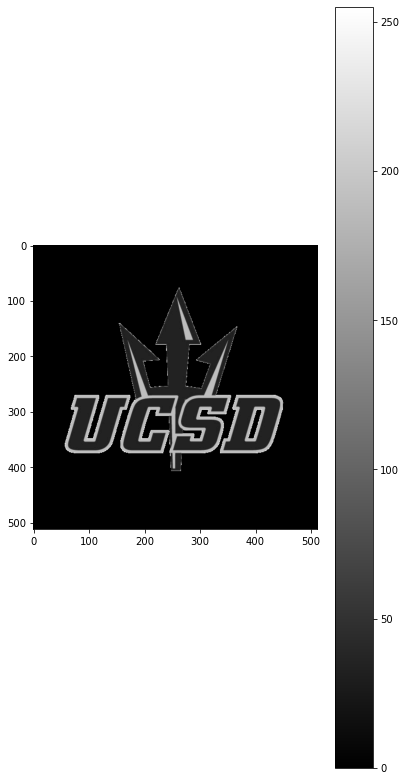

In [24]:
# read an image file
M = 512 # number of rows
N = 512  # number of columns 

x = np.arange(0,N)  # horizontal grid 
y = np.arange(0,M)  # vertical grid 
xx, yy = np.meshgrid(x, y)

#image = Image.open('image.png').convert("L")
img1 = matplotlib.pyplot.imread('image.png')

# convert image to grayscale
plt.gray()
# resize image to 512 times 512
image = image.resize((512,512))
# plot image
fig = plt.figure(figsize =(14,14))
plt.subplot(1, 2, 1)

plt.imshow(image, cmap="gray", aspect='equal')  # imshow is how we plot images, cmap is colormap
plt.colorbar()


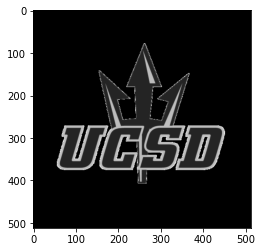

In [19]:
fname = 'UCSD-logo.png'
image = Image.open(fname).convert("L")
arr = np.asarray(image)
plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.show()

# 2) Blockwise DCT transform

The JPEG compression algorithm is based on dividing the image up into blocks (or image patches).  
In the following block write a fucntion that will 
- break up the image into 2D disjoint patches of $8 \times 8$. 
- apply the ```dct2``` function defined above to each patch. 
- The output is an $M \times N$ image where each block has been transform into DCT coefficients.  

Note the patches are disjoint and do not overlap. The upper-left coordinates of the patches are $(0,0),(0,8),(0,16),...,(8,0),(8,8),...(16,0),(16,8),...,(M-8,N-8)$.

In [70]:
img_arr = np.asarray(image)
patches = []
for n in np.arange(512):
    for k in np.arange(8):
        patch = (img_arr[n])[k * 8:(k+1) *8]
        patches.append(patch)

In [79]:
patches[38:46]

[array([0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)]

In [64]:
len(patches)

64

In [68]:
len(patches[0][0])

512

In [65]:
len(patches)

8

In [69]:
(img_arr[0])[0:8]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [55]:
patch = img_arr[0:1]

In [57]:
len(patch[0])

512

In [103]:
image2 = np.asarray(image)

In [104]:
len(image2) % 8 == 0

True

In [106]:
len(image2[0]) % 8 == 0

True

In [107]:
def dct_block_image(image):
    image2 = np.asarray(image)
    # verify image height and width are multiples of 8
    if (len(image2) % 8 == 0) & (len(image2[0]) %8 == 0):
        return True
    return False

In [108]:
dct_block_image(image)

True

In the follwing block write a fucntion that will plot 
- an $8 \times 8$ block from the original image 
- the DCT applied to that block.  (Note you may want to control the ```vmax``` input value in ```imshow``` or apply a log transform in order to see a better range of valeus of the image)

In [111]:
dct_img = dct_block_image(image)

# the top left corner of the image block
r = 128
c = 128

# plot the block from image
dct2(patches[38:46])
# plot the dct of that block


array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

Note the top-left corner element (coefficient of $(u=0,v=0)$ basis function) has large magnitude. This is the DC coefficient (also called the constant component), which defines the mean value for the entire block. The remaining 63 coefficients are the AC coefficients (also called the alternating components).  
The advantage of the DCT is its tendency to aggregate most of the signal in the top left corner (or low frequency coefficients), as may be seen above. 

Now plot the full DCT block image ```dct_img```.

In [ ]:
# plot full DCT-block image


# 3) Compression workflow and evaluation metrics
We will compare two methods of compressing the image using the DCT.   
Both compression frameworks are based on the following workflow. First the image is transformed to a block-DCT image. Then some of the coefficients are zeroed out based on a thresholding scheme. Compression takes place by only the non-zero values being stored. Thus we measure the level of compression by the **percentage of non-zero values** (number of non-zeros divided by total number of pixels). Upon receiving the thresholded block-DCT image, an inverse block-DCT is applied and we obtain the compressed image.  

A good compression algorithm outputs an image that is as similar as possible to the original image, but requires much less elements to store.  
Therefore to evaulte the compression scheme, we will measure image quality using the **mean square error**:
$$ MSE = \frac{1}{MN} \sum_m \sum_n (I[m,n]-I_\textrm{compressed}[m,n])^2$$  
Note that other measures exist to quantify the quality of an image, some of which are tuned to human visual perception. 

# 4) Compression - global thresholding
For the first framework we will aplly a global threshold to the DCT-block transformed image.  

In the two blocks below write 
- a function that takes as input the DCT block image and a threshold value $\tau$. The function will zero out all DCT coefficients that are below $\tau$ times the **maximum absolute value** of all DCT blocks. The function will output the thresholded image and the percentage of non-zero values in the thresholded image.
- a function that takes as input an image, breaks it up into 2D patches of size $8 \times 8$ and applies the inverse DCT transform (```idct2``` function defined above) to each patch. The output is an $M \times N$ image where each block has been transformed back into the spatial domain.  

In [ ]:
def threshold_image(dct_image,tau = 0.1):
    # remeber to return two output variables
    return

In [ ]:
def inverse_dct_block_image(dct_image):
    # verify image height and width are multiples of 8
    return

Now apply the thresholding function with $\tau=0.1$ to the DCT-block transform image and invert it back to the spatial domain. 
Then plot 
- the original image
- the image after global thresholding  
- the difference image between the two, where the difference image is the **absolute value** of the difference between the two images

In [ ]:
# applying thresholding and invert block-DCT

In [ ]:
# plot images

### Question
What properties do you notice about the compressed image? What artifcats have been introduced to the image? What information has been removed or reduced? (You may should zoom-in to fully understand this question).



### Answer

# 5) Evaluation
In the compression algorithm you implemented, the threshold controls the compression rate as it implicitly determines the number of non-zeros retained in the image.  We want to evaluate how distorted the image is after compression.
We will use MSE between the image after compression and the original image as a quality measure.

In the block below you will loop over a range of threshold values.
For each threshold value
- apply the thresholding function and the block inverse-DCT
- store in an array the percentage of non-zeros values that remained after thresholding
- store in an array the mean squared error (MSE) between the original iamge and the compressed image
- Plot 3 subplots of the original image, the image after global thresholding and the difference image between the two.



In [ ]:
thresholds = np.arange(0.01,0.15,0.01)

# create output arrays for percentage of non-zeros and MSE

# loop over thresholds


### Question 
What do you notice visually as the threshold increases? What features are most affected by the compression?

### Answer

In the block below plot the following
- thresholds vs MSE
- thresholds vs percentage of non-zeros
- percentage of non-zeros vs MSE

In [ ]:
# 3 plots

### Question
What do you notice as the threshold increases? How does it affect the MSE? How does it affect the number of non-zeros? What is the relaitonship between MSE and the number of non-zeros?

### Answer

# 6) Local block - based compression

Now we will implement a block based compression approach.
In the block below, write a function that takes as input the DCT-block image and $k$ - number of non-zero values to retain in each block (what are the minimum and maximum possible values of $k$?).   
The function will loop over the $8 \times 8$ blocks and for each block keep only the $k$ elements with highest **absolute value**.  
The function will output the DCT-block image after block thresholding and the percentage of non-zero values in the thresholded image (hint: this value depends on $k$).

In [ ]:
def dct_block_threshold(dct_image, k=7):
    return

Now apply the block thresholding function with $k=7$ to the DCT-block transform image and invert it back to the spatial domain. 
Plot 
- the original image
- the image after local compression 
- the difference image between the two, where the difference image is the absolute value of the difference between the two images

In the block below you will loop over a range of $k$ values to retain in each block.
For each $k$ value
- apply the block thresholding function and the block inverse-DCT function 
- store in an array the percentage of non-zeros values that remained after thresholding
- store in an array the mean squared error (MSE) between the original iamge and the compressed image
- Plot 3 subplots of the original image, the image after local compression and the difference image between the two.



In [ ]:
k_vals = np.arange(1,9) # number of non-zeros to retain in each block

# create output arrays for percentage of non-zeros and MSE

# loop over number of non-zeros to retain


# 7) Method comparison 
In the block below plot the percentage of non-zeros vs MSE for both global and local thresholding

### Question: 
Which method performs better?

### Answer 
 